# **Chicago Crime Analysis**

**Author:** Meg Hutch

**Date:** June 7, 2020

**Data source:** Data was accessed from [data.cityofchicago](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2). 

As described on their website:
> "This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system."

In this analysis several machine and deep learning methods are implemented to examine the utility of these advanced analytic methods in predicting crime in the city of Chicago which occured in from January-May of 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
crime_df = pd.read_csv(r'C:\\Users\\User\\Box Sync/Projects/Chicago_Crimes/Crimes_-_2001_to_present.csv')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **Methods**

### **Data Pre-Processing**

Several pre-processing steps were required to work with the data. 

The dataset was modified as follows:

1. Filter for cimes occuring in 2020
2. Remove white space from column names
3. Concatenate Primary_Type and Description
4. Convert Community_Area to type 'object'
5. Remove Primary_Type categories that occured < 1000 times
6. Remove missing values

In [3]:
# Step 1
crime_df = crime_df[crime_df['Year'] == 2020]

# Step 2
crime_df.columns = crime_df.columns.str.replace(' ', '_')

# Step 3
crime_df["Primary_Type_Description"] = crime_df["Primary_Type"] + " " +  crime_df["Description"]

# Step 4
crime_df['Community_Area'] = crime_df['Community_Area'].astype(object)

# Step 5
crime_df['freq'] = crime_df.groupby('Primary_Type')['Primary_Type'].transform('count')
crime_df = crime_df[crime_df.groupby('Primary_Type').freq.transform(len) > 1000]

# Step 6
crime_df = crime_df.dropna()

After our initial pre-processing step, we see that there are 75,628 crimes and 12 unique crimes that occured from January-June 2020

In [4]:
print('Number of Observations:', crime_df.shape)
unique, counts = np.unique(crime_df.Primary_Type, return_counts = True)
print('Number of Unique Crimes:',  len(unique))

Number of Observations: (75628, 24)
Number of Unique Crimes: 12


### **Model Preparation**

From exporing the data, many columns appear to be collinear to one another, and thus, inlcuding all predictors would be redundant, esecially when we consider the size of the dataset. For example, IURC (Illinois Unifrom Crime Reporting code) is said to be "Directly linked to the Primary Type and Description". Simiarly, FBI Code is a variable that describes the type of crime. Because our aim is to predict the type of crime (Primary_Type), we must remove any variables that may leak information about our primary outcome. 

**Step 1**, shows the data we decided to keep in our preliminary models.

1. Select columns of interest - we keep **Primary_Type**, **Arrest**, **Domestic**, **Location_Description**, and **Community_Area**. 

After selecting our columns of interest, we further divide our dataset into inputs (crime_x) and our output variable (crime_y).

2. Create x and y dataframes

In **Steps 3 and 4** we process the x and y dataframes appropriately. All inputs in crime_x are one-hot encoded, while crime_y categorical values are recoded as numbers instead. Additonally, we save a list of column names (important for random forest feature selection).
3. One-hot encode categorical inputs in crime_x - save column list
4. Recode crime_y to convert categorical labels to numeric

Next, we format data as arrays and reshape the y set.

5. Convert dataframes to arrays and reshape crime_y

Lastly, we shuffle and then split our x and y datasets into training and test sets, using a 75/25% split. Additionally, our primary outcome variable, Primary_Type, is stratified to ensure that each class of our outcome is proportionally represented in each dataset. 

6. Split data into training and testing sets

In [6]:
# Step 1
crime_model = crime_df[['Primary_Type', 'Location_Description', 'Arrest', 'Domestic', 'Community_Area']]

# Step 2
crime_x = crime_model[['Location_Description', 'Arrest', 'Domestic', 'Community_Area']]
crime_y = crime_model[['Primary_Type']]

# Step 3
crime_x.loc[:, 'Arrest'] = pd.factorize(crime_x['Arrest'])[0].reshape(-1,1)
crime_x.loc[:, 'Domestic'] = pd.factorize(crime_x['Domestic'])[0].reshape(-1,1)
crime_x = pd.get_dummies(crime_x)
crime_x_col_names = list(crime_x.columns.values) 

# Step 4
crime_y.loc[:, 'Primary_Type_Code'] = pd.factorize(crime_y['Primary_Type'])[0].reshape(-1,1)
crime_list = crime_y[['Primary_Type', 'Primary_Type_Code']].drop_duplicates()
crime_y = crime_y[['Primary_Type_Code']]

# Step 5
crime_x = np.array(crime_x)
crime_y = np.array(crime_y)

crime_y = crime_y.reshape(-1)

# Step 6
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
sss.get_n_splits(crime_x, crime_y)

for train_index, test_index in sss.split(crime_x, crime_y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = crime_x[train_index], crime_x[test_index]
    y_train, y_test = crime_y[train_index], crime_y[test_index]

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


TRAIN: [69714  7928 48593 ... 31234 18461 16908] TEST: [20038 13366  1725 ... 29207 10927 13728]


## **Functions for Models**

Functions adapated from: [github.com/geickelb](https://github.com/geickelb/HSIP442_guest_lecture/blob/master/notebooks/modeling.ipynb)

### **Logistic Regression**

**ROC Curve**

This function will print an ROC Curve.

In [8]:
# View ROC Curve
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Recievor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

**Evaluate Model**

This function includes parameters for cross-fold validation and will return a plot of the area under the curve for each test. Additionally, as we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [9]:
def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import StratifiedKFold

    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=StratifiedKFold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')

    print ('the AUC is: {:0.3f}'.format(auc))
    
    # Modify labels for the classification reports
    crime_labels = list(range(0,11))
    crime_labels = np.asarray(crime_labels)
    
    crime_names = crime_list.Primary_Type.tolist()
    
    print("classification report:\n ", classification_report(y, y_hat, labels = crime_labels, target_names = crime_names, digits=3))

    #ez_roc(model, x, y, pos_label = 1) #plotting roc curve
    #plt.show()

### **Random Forest**

This function includes parameters for stratified cross-fold validation and supports code for hyperparameter tuning for a random forest model. Because we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [10]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = 'roc_auc_ovo_weighted', verbose=True, cv = True, 
                    return_train_score = True): 
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
    #scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=StratifiedKFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)
    
    #scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
    #scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
    
    #OneVsRestClassifier(grid_search.fit(X, y))   
    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
    #print(grid_search.cv_results_)

# **Analyses & Results**

### **Descriptives**

**Top 10 Crimes**

The top 10 crimes within the whole dataset included: 

1. Theft
2. Battery
3. Criminal Damage
4. Narcotics
5. Assault
6. Other Offense
7. Motor Vehicle Theft
8. Deceptive Practice and Robbery.
9. 
10. 

Text(0.5, 1.0, 'Top 10 Crimes')

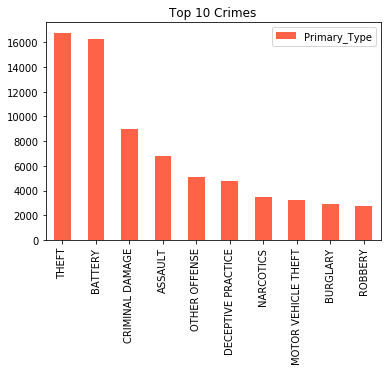

In [11]:
crime_df10 = crime_model.Primary_Type.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crimes")

**Top 10 Crime Locations**

Text(0.5, 1.0, 'Top 10 Locations')

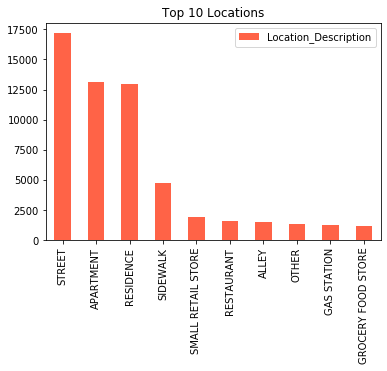

In [12]:
crime_df10 = crime_model.Location_Description.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")

**Top 10 Communities**

Text(0.5, 1.0, 'Top 10 Communities')

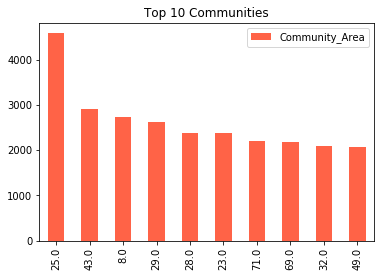

In [13]:
crime_df10 = crime_model.Community_Area.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

**Domestic**

Text(0.5, 1.0, 'Top 10 Communities')

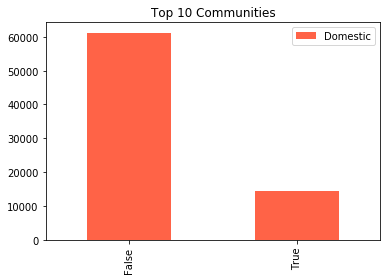

In [14]:
crime_df10 = crime_model.Domestic.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

**Domestic Crimes**

Text(0.5, 1.0, 'Top 10 Communities')

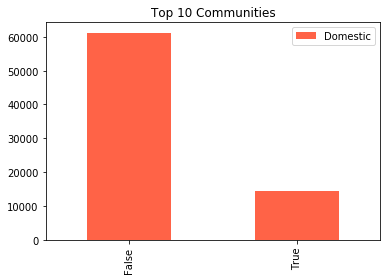

In [15]:
crime_df10 = crime_model.Domestic.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Communities")

## **Logistic Regression**

Logistic regression was performed with an l2 penality and with solver = 'sag' (Stochastic Average Gradient descent), which can minimize the cost function more quickly for large datasets. Predictions were made using One vs One (OVO) multi-classification which compares each pair-wise class. 

Through 5-cross fold validation with the training set, our average AUC was 0.797. 

We also print out a classification report from one of the folds which includes the precision, recall, f1-score, and support (# of samples), for each outcome. We see that outcome 4 (X) had the highest recall (0.700), f1-score (0.502). It however, also had the highest number of observations (46,220). Class 0 (X) had the highest precision (0.538), however a very small recall and f1-score (0.007 and 0.014 respectively). These results make more sense in light of the fact that there were < 1000 observations in this class.

### **Evaluation of Training Data**

In [16]:
# reshape data
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [17]:
t1 = time.time()

lr = LogisticRegression(penalty='l2', solver='sag', random_state = 12345)
#fit model
lr.fit(X_train, y_train)
#evaluate model (on training data)
evaluate_model(lr, X_train, y_train, cv = True)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

across 5 fold cv on trainingset, the model had 
 mean auroc: 0.797 
 std auroc: 0.001
###metrics on provided dataset:###
the AUC is: 0.791


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))


classification report:
                       precision    recall  f1-score   support

              THEFT      0.399     0.708     0.510     12584
      OTHER OFFENSE      0.097     0.006     0.012      3847
            ASSAULT      0.313     0.010     0.019      5095
            BATTERY      0.512     0.657     0.575     12186
           BURGLARY      0.361     0.165     0.226      2165
 DECEPTIVE PRACTICE      0.320     0.402     0.357      3601
    CRIMINAL DAMAGE      0.238     0.194     0.213      6718
          NARCOTICS      0.493     0.795     0.608      2621
  WEAPONS VIOLATION      0.336     0.178     0.233      1934
            ROBBERY      0.319     0.117     0.171      2071
MOTOR VEHICLE THEFT      0.259     0.068     0.107      2425

          micro avg      0.409     0.415     0.412     55247
          macro avg      0.332     0.300     0.276     55247
       weighted avg      0.362     0.415     0.352     55247

Training Time in Minutes: -6.543017141024271


### **Evaluation of Testing Data**

We obtained a final AUC of 0.738 on the testing set. This result is only slightly lower than the average AUC of the training set described above (0.738 vs 0.746). Similarly as to what was reported above, crime 4 (X) had the highest recall (0.71), while crime 0 (X) had the highest precision. We can see through the classification report that our model has a wide range of performance success/failure depending on the outcome of interst. However, when examining outcome 2, 4, and 8 which had the highest recall scores, we can notice that these classes also had the highest number of samples. Interestingly, class 3 and 5, have the fourth and fifth highest number of samples, however, their recalls are 0.001 and 0.080 respectively. 

In [18]:
evaluate_model(lr, X_test, y_test, cv = False)

###metrics on provided dataset:###
the AUC is: 0.787
classification report:
                       precision    recall  f1-score   support

              THEFT      0.401     0.706     0.512      4194
      OTHER OFFENSE      0.075     0.006     0.012      1282
            ASSAULT      0.185     0.006     0.011      1699
            BATTERY      0.509     0.660     0.574      4062
           BURGLARY      0.331     0.130     0.187       721
 DECEPTIVE PRACTICE      0.308     0.394     0.346      1201
    CRIMINAL DAMAGE      0.210     0.169     0.187      2239
          NARCOTICS      0.467     0.761     0.579       874
  WEAPONS VIOLATION      0.298     0.161     0.209       645
            ROBBERY      0.252     0.091     0.134       690
MOTOR VEHICLE THEFT      0.226     0.062     0.097       809

          micro avg      0.401     0.406     0.404     18416
          macro avg      0.297     0.286     0.259     18416
       weighted avg      0.337     0.406     0.342     18416



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))


## **Random Forest**

1. First, we specify a parameter grid where we explore models by changing a number of parameters including:  max_depth, min_samples_split, and min_samples_leaf

2. We then instatiate a RandomForestClassifier with criterion 'entropy'

3. We can call the previously defined hypertuning_fxn above, and perform 5 cross-fold valdiation on our crime data. Once again we assess classification performing using one-vs-one. 

**Reshape y data**

In [19]:
y_train = y_train.ravel()
y_test = y_test.ravel()

### **Set Hyperparameters and Run Models**

Our hyperparameter searching identified that the best performing model had a cross-validation score of 0.733 and its parameters were set as follows:

```max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100```

In [20]:
# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

t1 = time.time()

model = RandomForestClassifier(criterion='entropy', random_state=12345)
rf_hyper = hypertuning_fxn(X_train, y_train, nfolds = 5, model = model , param_grid = param_grid, scoring = 'roc_auc_ovo_weighted', cv = True, return_train_score = True)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

 scorer function: roc_auc_ovo_weighted
 ##### CV performance: mean & sd scores #####
best cv score: 0.789
best cv params:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
worst cv score: 0.782
worst cv params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.782 (+/-0.002) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.782 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.782 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples

### **Return the Best Estimator**

In [21]:
print(rf_hyper.best_estimator_)
rf = rf_hyper.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


## **Evaluation of Training Data**

On our testing set, our best performing random forest model had an AUC of 0.732. Similar to our logistic regression models, class 4 had the highest recall (0.818). Class 8, had a precision of 0.635 and recall of 0.130, despite having a fairly high number of samples (10,664). Class 12 had the highest precision (0.741). Also, noteworthy, the majority of samples had virtually 0 recall and precision.

In [22]:
t1 = time.time()

evaluate_model(rf_hyper.best_estimator_, X_train, y_train, cv=False)

t2 = time.time()

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

###metrics on provided dataset:###
the AUC is: 0.788
classification report:
                       precision    recall  f1-score   support

              THEFT      0.307     0.925     0.461     12584
      OTHER OFFENSE      0.000     0.000     0.000      3847
            ASSAULT      0.000     0.000     0.000      5095
            BATTERY      0.531     0.615     0.570     12186
           BURGLARY      0.000     0.000     0.000      2165
 DECEPTIVE PRACTICE      0.734     0.048     0.091      3601
    CRIMINAL DAMAGE      0.000     0.000     0.000      6718
          NARCOTICS      0.481     0.821     0.606      2621
  WEAPONS VIOLATION      0.000     0.000     0.000      1934
            ROBBERY      0.000     0.000     0.000      2071
MOTOR VEHICLE THEFT      0.000     0.000     0.000      2425

          micro avg      0.378     0.388     0.383     55247
          macro avg      0.187     0.219     0.157     55247
       weighted avg      0.258     0.388     0.265     55247

Trai

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Evaluation of Testing Data**

Our best performing random forest classifier achieved an AUC of 0.725 on the testing set. Comparing evaluation on the training and testing sets, we can see that our results are fairly similar. 

In [23]:
evaluate_model(rf_hyper.best_estimator_, X_test, y_test, cv = False)

###metrics on provided dataset:###
the AUC is: 0.780
classification report:
                       precision    recall  f1-score   support

              THEFT      0.308     0.924     0.462      4194
      OTHER OFFENSE      0.000     0.000     0.000      1282
            ASSAULT      0.000     0.000     0.000      1699
            BATTERY      0.526     0.620     0.569      4062
           BURGLARY      0.000     0.000     0.000       721
 DECEPTIVE PRACTICE      0.717     0.055     0.102      1201
    CRIMINAL DAMAGE      0.000     0.000     0.000      2239
          NARCOTICS      0.474     0.793     0.593       874
  WEAPONS VIOLATION      0.000     0.000     0.000       645
            ROBBERY      0.000     0.000     0.000       690
MOTOR VEHICLE THEFT      0.000     0.000     0.000       809

          micro avg      0.378     0.388     0.383     18416
          macro avg      0.184     0.217     0.157     18416
       weighted avg      0.255     0.388     0.266     18416



C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1989: UserWarning: labels size, 11, does not match size of target_names, 12
  .format(len(labels), len(target_names))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Feature Importance**

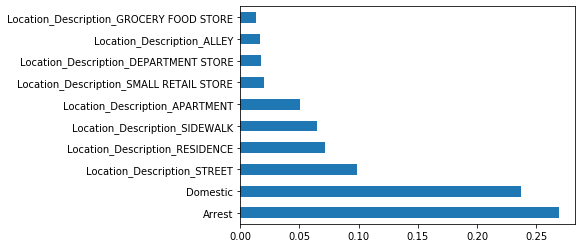

In [25]:
# create empty list
feat_impts = [] 
# bind all rf estimators for each classifier 
for clf in rf_hyper.best_estimator_:
    feat_impts.append(clf.feature_importances_)

# calculate the mean of features across predictors
feat = np.mean(feat_impts, axis=0)
# create a list of features (predictor names)
features = crime_x_col_names
# add predictor names to the means
feat_importances = pd.Series(feat, index = features)   

# plot feature importance for nlargest means 
feat_importances.nlargest(10).plot(kind='barh')

# Deep Learning

### **Data Pre-processing for Neural Network**

In [35]:
# Create a tensor from Numpy array
xb = torch.from_numpy(X_train).float()
yb = torch.from_numpy(y_train).float()
trainloader = TensorDataset(xb, yb)

### **Define Neural Network Architecture**

In [36]:
nn_model = nn.Sequential(nn.Linear(213, 100),
                          nn.ReLU(),
                          nn.Linear(100, 50), 
                          nn.ReLU(), 
                          nn.Linear(50, 17))

### **Set Neural Network Hyper-parameters**

In [37]:
batch_size = 10
learning_rate = 0.01
optimizer = optim.SGD(nn_model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
n_epochs = 100
trainloader = torch.utils.data.DataLoader(trainloader, batch_size, shuffle = True)

### **Evaluation of Training Data**

In [38]:
t1 = time.time()

# store running loss
total_step = len(trainloader)
loss_list = []
acc_list = []
running_loss_res = []

for e in range(n_epochs):
    # Define running loss as 0
    running_loss = 0

    # Run the model for each xb, yb in the trainloader.  
    for i, (xb, yb) in enumerate(trainloader):
        # clear gradients - otherwise they are stored
        optimizer.zero_grad()
        # Training pass
        output = nn_model.forward(xb)
        # caluclate loss calculated from the model output compared to the labels
        loss = criterion(output, yb.long()) 
        # backpropagate the loss
        loss.backward()
        # step function to update the weights
        optimizer.step()
        # record losses
        loss_list.append(loss.item()) 
        
        # Track the accuracy
        total = yb.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == yb).sum().item()
        acc_list.append((correct /total)*100)

        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. 
        # += function: Adds the running_loss (0) with loss.item and assigns back to running_loss
    else:
        print("Epoch {}/{}, Training loss: {:.5f}".format(e+1, n_epochs, running_loss/len(trainloader)))
        
        # append all running_losses
        running_loss_res.append(running_loss/len(trainloader))
        
        
t2 = time.time()
run_time = t1-t2

train_loss = np.mean(running_loss_res)
train_accuracy = np.mean(acc_list)

print('Train Loss (mean)', train_loss)
print('Train Accuracy', train_accuracy)
print('Training time in minutes:', run_time/60)

Epoch 1/100, Training loss: 2.18814
Epoch 2/100, Training loss: 1.87090
Epoch 3/100, Training loss: 1.79658
Epoch 4/100, Training loss: 1.76360
Epoch 5/100, Training loss: 1.74645
Epoch 6/100, Training loss: 1.73516
Epoch 7/100, Training loss: 1.72680
Epoch 8/100, Training loss: 1.71821
Epoch 9/100, Training loss: 1.71113
Epoch 10/100, Training loss: 1.70459
Epoch 11/100, Training loss: 1.69964
Epoch 12/100, Training loss: 1.69545
Epoch 13/100, Training loss: 1.69143
Epoch 14/100, Training loss: 1.68897
Epoch 15/100, Training loss: 1.68544
Epoch 16/100, Training loss: 1.68216
Epoch 17/100, Training loss: 1.68014
Epoch 18/100, Training loss: 1.67726
Epoch 19/100, Training loss: 1.67578
Epoch 20/100, Training loss: 1.67273
Epoch 21/100, Training loss: 1.67052
Epoch 22/100, Training loss: 1.66876
Epoch 23/100, Training loss: 1.66715
Epoch 24/100, Training loss: 1.66531
Epoch 25/100, Training loss: 1.66296
Epoch 26/100, Training loss: 1.66131
Epoch 27/100, Training loss: 1.66023
Epoch 28/1

### **Plot Training Loss and Accuracy Over Time**

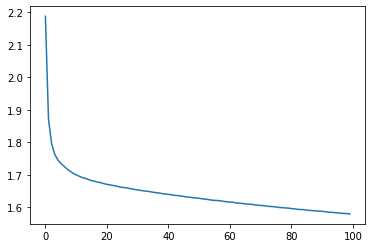

In [39]:
%matplotlib inline

test = list(range(100)) # number of epochs
plt.plot(test, running_loss_res)

## **Evaluate the Testing Data**

In [41]:
# Convert arrays into tensors
xb = torch.from_numpy(X_test).float()
yb = torch.from_numpy(y_test).float()

# Apply the model to the testing dataset
# Thus will enable us to see the predictions for each class
ps = nn_model(xb)

# Obtain the top prediction
top_p, top_class = ps.topk(1, dim=1)

# Drop the grad by using detach
top_p = top_p.detach().numpy()
top_class = top_class.detach().numpy()

yb = yb.reshape(-1,1)

# convert to integers
top_class = top_class.astype(np.int)

# convert to dataframe
top_class = pd.DataFrame(top_class)
yb = np.asarray(yb)
yb = pd.DataFrame(yb)

# change column names
top_class.columns = ["Predicted"]
yb.columns = ["True Label"]

results = pd.merge(top_class, yb, left_index=True, right_index=True)

results['Accurate'] = np.where(results['Predicted']==results['True Label'], 1, 0)

print('Testing Accuracy:', sum(results.Accurate)/len(results)*100)

Testing Accuracy: 40.16501824721003


# K-Nearest-Neighbors

In [ ]:
# two neighbors will bring the point itself, and then its next nearest neighbor
neighbors = NearestNeighbors(n_neighbors = 2).fit()

print(neighbors.head(10))

# rebind the true labels for the test sets
# convert list to dataframe?
#neigh_df = pd.DataFrame(n)

# K-means Clustering

### **Cluster by Crime**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score

kmeans = KMeans(n_clusters = 17, init= 'k-means++', n_init = 10, random_state=0)
kmeans.fit(X_train)
k_labs = kmeans.labels_
preds = kmeans.predict(X_test)

print(adjusted_mutual_info(preds, y_test))

### **Cluster by Location**

In [ ]:
kmeans = KMeans(n_clusters = 17, init= 'k-means++', n_init = 10, random_state=0)
kmeans.fit(X_train)
k_labs = kmeans.labels_
preds = kmeans.predict(X_test)

print(adjusted_mutual_info(preds, y_test))

# Conclusions

In our analysis we found....

Compare all results...can I make a nice table with these even if I import it into the notebook?

**Maybe re-look at primary type description?**

## Potential Impact

This analysis benefits our understanding of where crimes are most likely to occur. Results from predictive models that can analyze data retrospectively, can be later used to prospectively motitor high-risk locations for specific crimes and faciliate implementation of protective measures. 

## Limitations

This analysis only analyzes crimes that occured in the first half of 2020, however, the full dataset includes crimes from 2001-Present. Thus, while our analysis may be more representative due to recent crimes, it is likely that our model would improve by including more data from past years. Additionally, this analysis did little hyperparameter tuning and thus, while our models were fairly strong, it is likely that may improve with more rigourous testing. 

## Next Steps

* Include data from 2001 through 2019
    - Can research the implementation of parallel processing to speed up data pre-processing and analysis
* Evaluate models after rigourous hyperparameter tuning
* Use machine and deep learning methods to identify which crimes/locations are harder to predict
* Utalizing advanced neural network models such as Recurrent Neural Networks that can better delineate the trajectory of certain crimes overtime and perhaps seasonally, ie: is theft more likely to occur in winter months?